In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import xgboost as xgb

In [2]:
# Load data
df = pd.read_csv(r"C:\Users\WERPELGA\Desktop\Databricks\01.IDE_Github_Databricks_Sync\filler_data_head_1_for_prediction_small.csv")

In [4]:
print(df.head())

               datetime_nz  target_head_y                 DateTime  \
0  2023-04-01 00:00:00.000     909.099976  2023-04-01 00:00:00.000   
1  2023-04-01 00:00:00.203     899.400024  2023-04-01 00:00:00.203   
2  2023-04-01 00:00:07.185     906.200012  2023-04-01 00:00:07.185   
3  2023-04-01 00:00:14.186     901.500000  2023-04-01 00:00:14.186   
4  2023-04-01 00:00:21.198     901.099976  2023-04-01 00:00:21.198   

   HVAC_HV01HT44.Control.Status.EUValue  HVAC_HV11PT41.Control.Status.EUValue  \
0                             39.799999                             39.000000   
1                             39.799999                             39.000000   
2                             39.799999                             38.900002   
3                             39.700001                             38.900002   
4                             39.799999                             39.000000   

   HVAC_HV11TT43.Control.Status.EUValue  MtFillerCanWeight.DanCan_Avg_Weight  \
0           

In [4]:
#Change the datetime column to datetime format
df['datetime_nz'] = pd.to_datetime(df['datetime_nz'])

In [5]:
# Add time difference feature
df['time_diff'] = df['datetime_nz'].diff().dt.total_seconds()
df = df.fillna(0)  # fill the first row of time_diff with 0

In [6]:
# Create moving averages feature
df['moving_avg_3'] = df['target_head_y'].rolling(window=3).mean()
df['moving_avg_7'] = df['target_head_y'].rolling(window=7).mean()

In [7]:
# Create dummy variables for day of week
df['day_of_week'] = df['datetime_nz'].dt.dayofweek
df = pd.get_dummies(df, columns=['day_of_week'])

In [8]:
# Drop rows with NaN values (caused by moving average calculation)
df = df.dropna()

In [9]:
df.drop(['DateTime'], axis=1, inplace=True)
df.drop(['datetime_nz'], axis=1, inplace=True)
df.drop(['MtFillerHeadData.CwPackageName'], axis=1, inplace=True)
df.drop(['MtFillerHeadData.NetWeightHead01'], axis=1, inplace=True)

In [10]:
# Split data
# 80% for training and 20% for testing
train_size = int(len(df) * 0.8)
train, test = df.iloc[0:train_size], df.iloc[train_size:]

In [11]:
# Use a Boolean mask to filter the DataFrame
mask = (train['target_head_y'] >= 885) & (train['target_head_y'] <= 950)

# Apply the mask
train = train[mask]

In [12]:
# Normalize features
# Scaling the features to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [13]:
# Function to create dataset from time series data
# This function will restructure the data so that the model can be trained to predict the can weight 
# at time t+1 based on the features at time t
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])  # assuming the target variable (can weight) is the first column
    return np.array(dataX), np.array(dataY)

In [14]:
# Prepare train and test datasets
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [15]:
# XGBoost model
def create_xgboost(param_grid):
    model = xgb.XGBRegressor()
    # Initialize the GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    return grid_search

In [16]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
}

In [17]:
# Fit the model
# xgb_clf = create_xgboost(param_grid=param_grid)
xgb_clf = xgb.XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5)
xgb_clf.fit(trainX.reshape(trainX.shape[0], trainX.shape[2]), trainY)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [18]:
# Predict the classes
preds = xgb_clf.predict(testX.reshape(testX.shape[0], testX.shape[2]))

# Print the accuracy score
print('Mean Squared Error: ', mean_squared_error(testY, preds))

Mean Squared Error:  0.1660820040942722


In [19]:
testY = testY.reshape(-1, 1)
# create a dummy array with the same shape as the original data
dummy_array = np.zeros((len(testY), 97))

# substitute your testY to the first column of the dummy array
dummy_array[:,0] = np.squeeze(testY)

# inverse transform the dummy array
inverse_transformed_array = scaler.inverse_transform(dummy_array)

# extract your result
testY_inv = inverse_transformed_array[:,0]

In [20]:
preds = preds.reshape(-1, 1)
# create a dummy array with the same shape as the original data
dummy_array = np.zeros((len(preds), 97))

# substitute your preds to the first column of the dummy array
dummy_array[:,0] = np.squeeze(preds)

# inverse transform the dummy array
inverse_transformed_array = scaler.inverse_transform(dummy_array)

# extract your result
preds_inv = inverse_transformed_array[:,0]

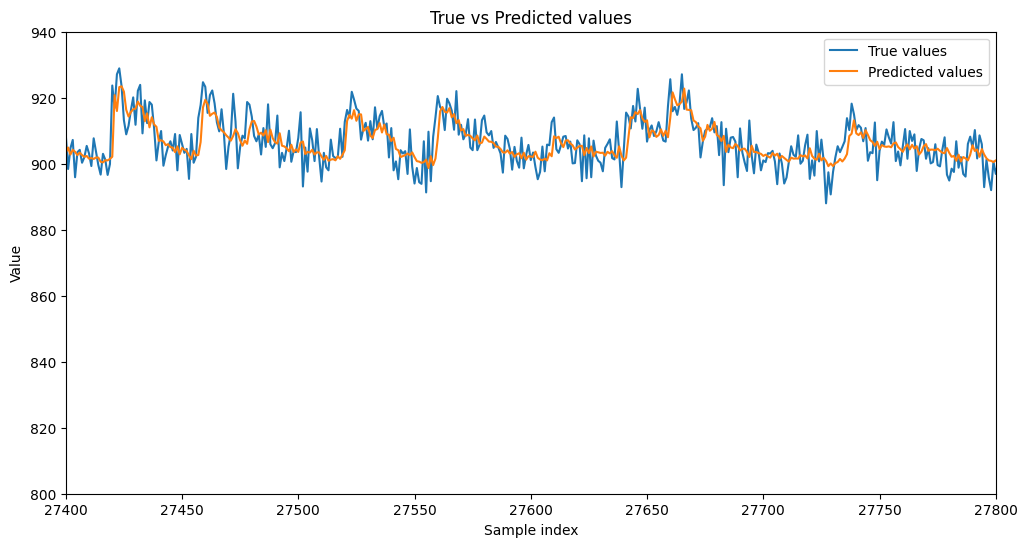

In [23]:
# Plot true values
plt.figure(figsize=(12, 6))
plt.plot(testY_inv, label='True values')

# Plot predicted values
plt.plot(preds_inv, label='Predicted values')
plt.title('True vs Predicted values')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.xlim(27400, 27800)
plt.ylim(800, 940)
plt.legend()
plt.show()